In [45]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import mu_to_p0
import inverse_problem

## Import this library if CUDA GPU is available
# import mu_to_p0_gpu

# Beer Law Photon Modeling

### This repository contains functions which are useful for simulating the attenuation of light through absoprtive mediums based on the principles of the Beer-Lambert Law for photon light modeling.

------

# Table of Contents
* [mu_to_p0_isotropic](#mu_to_p0_isotropic)
* [mu_to_p0_isotropic_3d](#mu_to_p0_isotropic_3d)
* [mu_to_p0_wedge](#mu_to_p0_wedge)
* [mu_to_p0_wedge_variable_beam](#mu_to_p0_wedge_variable_beam)
* [mu_to_p0_cone_3d](#mu_to_p0_cone_3d)
* [mu_to_p0_wedge_3d](#mu_to_p0_wedge_3d)
* [mu_to_p0_wedge_variable_beam_3d](#mu_to_p0_wedge_variable_beam_3d)
* [mu_to_p0_cone_variable_beam_3d](#mu_to_p0_cone_variable_beam_3d)
* [mu_to_p0_cone_stacked_cone](#mu_to_p0_cone_stacked_cone)
* [mu_to_p0_wedge_3d](#mu_to_p0_wedge_3d)
* [p0_to_H_cone](#p0_to_H_cone)
* [p0_to_sparseH_cone](#p0_to_sparseH_cone)
* [p0_to_H_stackedCone](#p0_to_H_stackedCone)

----------

<a id="mu_to_p0_isotropic"></a>
# `mu_to_p0_isotropic`



### Mathematical description
#### This function describes

### $$ p_0(x, y) = \frac{\mu(x, y)}{\pi d^2} e^{-\sum_{i=0}^{n-1} \mu(x_i, y_i) h} $$

### $$ a(x, y) = \sum_{i=0}^{n-1} \mu(x_i, y_i) h $$


### $$ f(x, y) = e^{-a(x, y)} \left(\frac{1}{\pi d^2}\right) $$

where :
* $p_0(x, y)$ is the initial amplitude at each point in the grid
* $a(x, y)$ is the accumulated amplitude at each point in the grid
* $f(x, y)$ is the fluence at each point in the grid
* $\mu(x,y)$ is the attenuation coefficient at the point $(x,y)$
* $d$ is the Euclidian distance between the source and the point $(x,y)$, calculated as $d = \sqrt{(x-x_s)^2 + (y - y_s)^2}$
* $n$ is the number of discrete points along the ray from the source to the point $(x,y)$, calculated as $n = \text{int}(d/h) + 1$
* h is the number of sampling points along the ray
* $(x_i, y_i)$ are the coordinates of the  $i\text{-th}$ point along the ray.
* $\mu(x_i, y_i)$ is the attenuation coefficient at the $i\text{-th}$ point along the ray. 

## Python Implementation

The function `mu_to_p0_isotropic` and the gpu-parallelized version, `mu_to_p0_gpu`,  accepts the following parameters:
* `mu`: A numpy array representing the attenuation coefficients at each point in a 2D grid.
* `mu_background`: A constant value representing the background attenuation coefficient. (any point outside the defined grid)
* `source`: A tuple containing the x and y coordinates of the light source.
* `h`: The spacing between sampling points along the ray.
* `xp`: A numpy array of x-coordinates in the physical space.
* `yp`: A numpy array of y-coordinates in the physical space.

and returns the following : 
* `P0`: The initial amplitude at each point in the grid
* `a`: the accumulated attenuation at each point in the grid
* `fluence`: The light fluence at each point in the grid

## Example Usage



In [46]:
# This is an annotated version of test_isotropic.py

# Here we are define a function for a "Gaussian Ball" to simulate some object in our space
def gauss_density_pattern(xp, yp, amplitude, sigma):
    x, y = np.meshgrid(xp, yp)
    x0 = xp.mean()
    y0 = yp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    return density

# Here we define the size in our x and y direction, in physical units
Lx = 5  # Size in x-direction
Ly = 5# Size in y-direction

# Here we define the size (and granularity) of our grid. These are proportional to the computational time.
nx = 64  # Number of grid points in x
ny = 64  # Number of grid points in y

# Here we just compute the grid spacing
dx = Lx/nx
dy = Ly/ny

# Here we create the coordinate arrays for our grid centered at 0. 
# If needed, we can change the FOV to be centered at any point here.
xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)

# Here we actually define our attenuation matrix using our Gaussian Ball.
# The choice of the amplitude and standard deviation of the Ball is arbitrary here.
mu = gauss_density_pattern(xc, yc, 0.5, Lx/10)

# We define a constant attenuation for any point outside the FOV
mu_background = 0.2

# We call the function and define our 3 variables, with the source at x = -Lx/2 - 1 y = -Ly/2 - 1 (a little outside the bottom-left corner of our FOV)
P0_1, a_1, fluence_1 = mu_to_p0.mu_to_p0_isotropic(mu, mu_background, (-Lx/2 - 3,-Ly/2 - 3), dx/4, xc, yc)


# Call for gpu parallelized function is essentially identical
# P0_1, a_1, fluence_1 = mu_to_p0_gpu.mu_to_p0_gpu(mu, mu_background, (-Lx/2 - 3,-Ly/2 - 3), dx/4, xc, yc)

### We can visualize the results using any preferred method

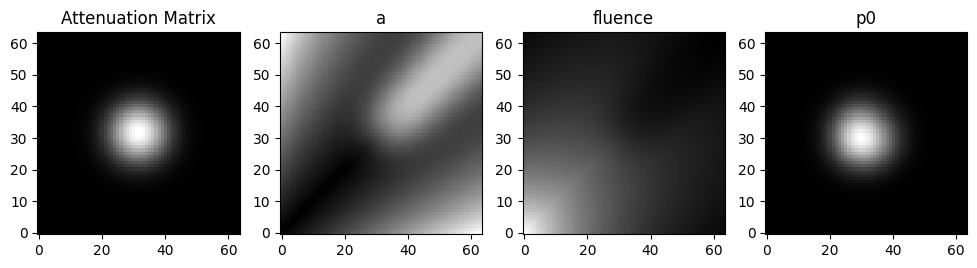

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].set_title("Attenuation Matrix")
ax[1].set_title("a")
ax[2].set_title("fluence")
ax[3].set_title("p0")

ax[0].imshow(mu, cmap="gray")
ax[1].imshow(a_1, cmap="gray")
ax[2].imshow(fluence_1, cmap="gray")
ax[3].imshow(P0_1, cmap="gray")

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()

plt.show()

---

<a id="mu_to_p0_isotropic_3d"></a>
# `mu_to_p0_isotropic_3d`



## Mathematical Description
The `mu_to_p0_isotropic_3d` function extends the `mu_to_p0_isotropic` to three dimensions, calculating the light fluence, initial amplitude, and accumulated attenuation in a 3D grid. The mathematical representation is similar but extends to three dimensions:

### $$ p_0(x, y, z) = \mu(x, y, z) e^{-\sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h} \cdot \left(\frac{3}{4 \pi d^3}\right) $$
### $$ a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h $$
### $$ f(x, y, z) = e^{-a(x, y, z)} \cdot \left(\frac{3}{4 \pi d^3}\right) $$

Where:
- $p_0(x, y, z)$ is the initial amplitude at each point in the grid
- $a(x, y, z)$ is the accumulated amplitude at each point in the grid
- $f(x, y, z)$ is the fluence at each point in the grid
- $\mu(x, y, z)$ is the attenuation coefficient at the point $(x, y, z)$.
- $d$ is the Euclidean distance from the source to the point $(x, y, z)$.
- $n$ is the number of discrete points along the ray from the source to the point.
- $h$ is the spacing between sampling points along the ray.
- $(x_i, y_i, z_i)$ are the coordinates of the $i$-th point along the ray.
- $\mu(x_i, y_i, z_i)$ is the attenuation coefficient at the $i$-th point along the ray.

## Python Implementation
The `mu_to_p0_isotropic_3d` and the gpu-parallelized function, `mu_to_p0_3d_gpu`, accepts the following parameters:
- `mu`: A 3D numpy array representing the attenuation coefficients at each point.
- `mu_background`: Background attenuation coefficient for points outside the defined grid.
- `source`: Tuple containing the x, y, and z coordinates of the light source.
- `h`: Spacing between sampling points along the ray.
- `xp`, `yp`, `zp`: Numpy arrays of x, y, and z coordinates in physical space.

The function returns:
- `P0`: Initial amplitude at each point in the 3D grid.
- `a`: Accumulated attenuation at each point.
- `fluence`: Light fluence at each point.

## Example Usage


In [5]:
# Annotated Version

# This function creates a 3D Gaussian density pattern, useful for simulating an object in a 3D space
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    # Create a 3D meshgrid for x, y, and z coordinates
    x, y, z = np.meshgrid(xp, yp, zp)
    
    # Calculate the mean of each coordinate array
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    
    # Apply the Gaussian formula in 3D
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    
    # Transpose the density matrix to match the zyx coordinate system
    density = np.transpose(density, (2, 1, 0))
    
    return density

# Define the size and granularity of the 3D grid
Lx = 5
Ly = 5
Lz = 5
nx = 32
ny = 32
nz = 32

# Compute the grid spacing for each dimension
dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

# Create coordinate arrays centered at 0 for each dimension
xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

# Generate the attenuation matrix using the 3D Gaussian density pattern
mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)

# We define a constant attenuation for any point outside the FOV
mu_background = .2

# Define the source location in 3D space, here the source is centered with respect to the z/y axes but on completely outside the and to the left of the x axis
source = (-Lx, 0, 0) # x, y, z

# Call the 3D isotropic function with the defined variables
P0_3D, a_3D, fluence_3D = mu_to_p0.mu_to_p0_isotropic_3d(mu, mu_background, source, dx/2, xc, yc, zc)

# Call for gpu parallelized function is essentially identical
#P0_3D, a_3D, fluence_3D = mu_to_p0_gpu.mu_to_p0_3d_gpu(mu, mu_background, source, dx/2, xc, yc, zc)


### We can visualize the results using any preferred method (here, maximum intensity projections)

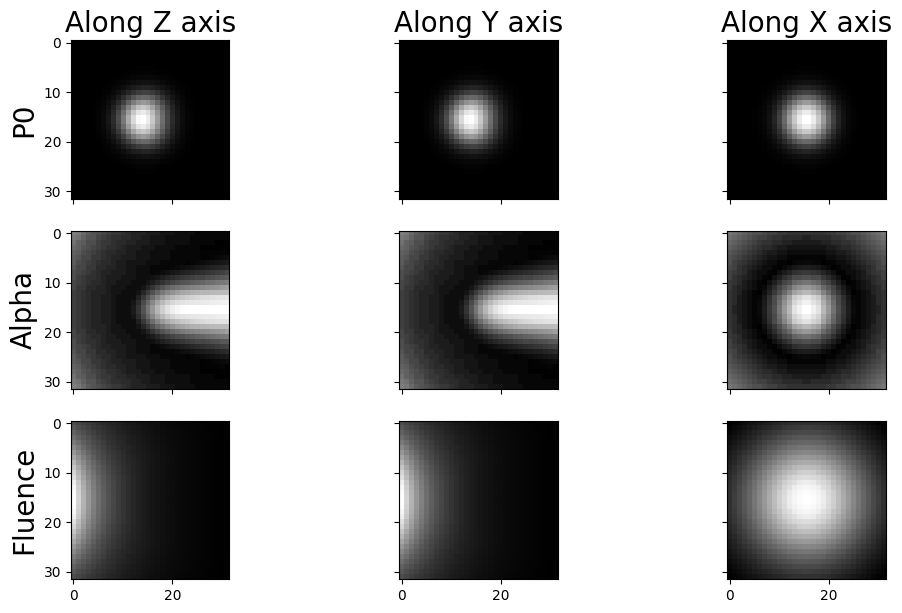

In [6]:
#Visualize
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True, sharey= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0_3D, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0_3D, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0_3D, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a_3D, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a_3D, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a_3D, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence_3D, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence_3D, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence_3D, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()


------

<a id="mu_to_p0_wedge"></a>
# `mu_to_p0_wedge`



## Mathematical Description
The `mu_to_p0_wedge` function simulates light attenuation through a medium with a directional "flashlight" effect, characterized by a specific angle (`theta`) and direction. This function is designed to model the behavior of a light source with directional characteristics, similar to a wedge or flashlight beam.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y)} = 
\begin{cases} 
1 & \text{if } |\arctan2(y - y_s, x - x_s) - \text{direction}| \leq \frac{\theta}{2} \\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y) = \sum_{i=0}^{n-1} \mu(x_i, y_i) h \text{ (along the ray path)}
$$

$$
p_0(x, y) = 
\begin{cases} 
\mu(x, y) e^{-a(x, y)} \left(\frac{1}{\pi d^2}\right) & \text{if M(x, y) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
\text{Fluence, } f(x, y) = 
\begin{cases} 
e^{-a(x, y)} \left(\frac{1}{\pi d^2}\right) & \text{if M(x, y) = 1} \\
0 & \text{otherwise}
\end{cases}
$$
</span>

Where:
- $M(x, y)$: A mask determining the area affected by the flashlight beam.
- $a(x, y)$: The accumulated attenuation at each point $(x, y)$.
- $p_0(x, y)$: The initial amplitude at each point $(x, y)$.
- $f(x, y)$: The fluence at each point $(x, y)$.
- $d$: The Euclidean distance from the source to point $(x, y)$, calculated as $d = \sqrt{(x-x_s)^2 + (y - y_s)^2}$.
- $n$: The number of discrete points along the ray from the source to point $(x, y)$, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i)$: The coordinates of the $i$-th point along the ray.
- $\mu(x, y)$: The attenuation coefficient at point $(x, y)$.
- $h$: The spacing between sampling points along the ray.
- $\mu(x_i, y_i)$: The attenuation coefficient at the \(i\)-th point along the ray.
- $\theta$: The angular width of the flashlight beam.
- $direction$: The orientation of the flashlight beam.

## Python Implementation

`mu_to_p0_wedge` and the GPU-Parallelized ,`mu_to_p0_wedge_gpu`, accepts and returns the following :

Parameters
- `mu`: A numpy array representing the attenuation coefficients at each point in a 2D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source`: A tuple containing the x and y coordinates of the light source.
- `h`: The spacing between sampling points along the ray.
- `xp`, `yp`: Numpy arrays of x-coordinates and y-coordinates in the physical space.
- `theta`: The angular width of the "flashlight" beam.
- `direction`: The direction in which the "flashlight" is pointed.

Returns
- `p0`: The initial light intensity at each point in the grid.
- `a`: The accumulated attenuation at each point in the grid.
- `fluence`: The light fluence at each point in the grid.

## Example Usage


In [7]:
def gauss_density_pattern(xp, yp, amplitude, sigma):
    x, y = np.meshgrid(xp, yp)
    x0 = xp.mean()
    y0 = yp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    return density

Lx = 10
Ly = 10

nx = 64
ny = 64

dx = Lx/nx
dy = Ly/ny

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)

mu = gauss_density_pattern(xc, yc, .5, Lx/10)
mu_background = .2

direction = 0
theta = np.pi / 10
source = (-10, 0)

P0_wedge, a_wedge, fluence_wedge = mu_to_p0.mu_to_p0_wedge(mu, mu_background, source, dx/4, xc, yc, theta, direction)
# GPU call is identical 
## P0_wedge, a_wedge, fluence_wedge = mu_to_p0_gpu.mu_to_p0_wedge_gpu(mu, mu_background, source, dx/4, xc, yc, theta, direction)

## Visualize

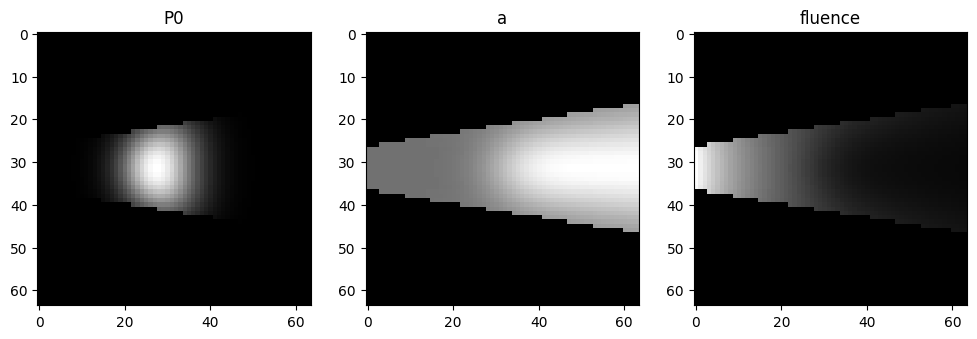

In [8]:
#Visualize
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].set_title("P0")
ax[1].set_title("a")
ax[2].set_title("fluence")

ax[0].imshow(P0_wedge, cmap = "gray")
ax[1].imshow(a_wedge, cmap = "gray")
ax[2].imshow(fluence_wedge, cmap = "gray")

---

<a id="mu_to_p0_wedge_variable_beam"></a>
# `mu_to_p0_wedge_variable_beam`

## Mathematical Description
The mu_to_p0_wedge_variable_beam function models light attenuation in a 2D space with a variable-intensity wedge-shaped beam, characterized by an angular width (theta) and a specific direction (direction). The function simulates a directional light source similar to a wedge beam with varying intensity across its spread.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y)} = 
\begin{cases} 
1 & \text{if } |\arctan2(y - y_s, x - x_s) - \text{direction}| \leq \frac{\theta}{2} \\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y) = \sum_{i=0}^{n-1} \mu(x_i, y_i) h
$$

$$
p_0(x, y) = 
\begin{cases} 
\mu(x, y) e^{-a(x, y)} \left(\frac{1}{\pi d^2}\right) \cdot I(\text{angle}) & \text{if M(x, y) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
f(x, y) = 
\begin{cases} 
e^{-a(x, y)} \left(\frac{1}{\pi d^2}\right) \cdot I(\text{angle}) & \text{if M(x, y) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
I(\text{angle}) = 
\begin{cases} 
\frac{\theta_{\text{cw}} - \text{angle}}{d_{\theta}} \cdot I[\text{index}_{\text{cw}}] + \frac{\text{angle} - \theta_{\text{ccw}}}{d_{\theta}} \cdot I[\text{index}_{\text{ccw}}] & \text{if angle within the beam}
\end{cases}
$$

</span>

Where : 
- $\theta_{cw}$ and $\theta_{ccw}$ are the angles immediately clockwise and counterclockwise to the angle, respectively, within the discretized intensity array $I$.
- $d_{\theta}$ is the angular increment between consecutive entries in the intensity array $I$.
- $index_{cw}$ and $index_{ccw}$ are the indices in the intensity array $I$ corresponding to $\theta_{cw}$ and $\theta_{ccw}$.
- angle is the angle at the current point relative to the direction of the wedge-shaped beam.
- $M(x, y)$: A mask determining the area affected by the flashlight beam.
- $a(x, y)$: The accumulated attenuation at each point $(x, y)$.
- $p_0(x, y)$: The initial amplitude at each point $(x, y)$.
- $f(x, y)$: The fluence at each point $(x, y)$.
- $d$: The Euclidean distance from the source to point $(x, y)$, calculated as $d = \sqrt{(x-x_s)^2 + (y - y_s)^2}$.
- $n$: The number of discrete points along the ray from the source to point $(x, y)$, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i)$: The coordinates of the $i$-th point along the ray.
- $\mu(x, y)$: The attenuation coefficient at point $(x, y)$.
- $h$: The spacing between sampling points along the ray.
- $\mu(x_i, y_i)$: The attenuation coefficient at the \(i\)-th point along the ray.
- $\theta$: The angular width of the flashlight beam.
- $direction$: The orientation of the flashlight beam.

## Python Implementation
Parameters
- `mu`: A numpy array representing the attenuation coefficients at each point in a 2D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source`: A tuple containing the x and y coordinates of the light source.
- `h`: The spacing between sampling points along the ray.
- `xp, yp`: Numpy arrays of x-coordinates and y-coordinates in the physical space.
- `theta`: The angular width of the "wedge" shaped beam.
- `direction`: The direction angle of the central axis of the wedge beam.
- `I`: An array representing the intensity distribution of the beam across different angles within the wedge's spread. This array allows the simulation of a beam whose intensity varies with angle. The function uses linear interpolation between the discrete intensity values in this array to determine the beam's intensity at specific points within its spread.

Returns
- `p0`: The initial light intensity at each point in the grid, calculated based on the wedge beam's spread, intensity variation, and attenuation.
- `a`: The accumulated attenuation at each point in the grid, taking into account the distance from the source and the attenuation coefficients.
- `fluence`: The light fluence at each point in the grid, representing the light intensity after accounting for attenuation and the distribution of the wedge beam.

## Example Usage

In [9]:
def gauss_density_pattern(xp, yp, amplitude, sigma):
    x, y = np.meshgrid(xp, yp)
    x0 = xp.mean()
    y0 = yp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    return density
def create_gaussian_array(size, center, sigma): # for creating I 
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

Lx = 10
Ly = 10

nx = 64
ny = 64

dx = Lx/nx
dy = Ly/ny

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)

mu = gauss_density_pattern(xc, yc, .50, Lx/10)
mu_background = .20

I = create_gaussian_array(11, 8, 5) # a beam of light whose center of greatest intensity is a bit off center
theta = np.pi/6
direction = 0
source = (-10,0)
P0_var_wedge, a_var_wedge, fluence_var_wedge = mu_to_p0.mu_to_p0_wedge_variable_beam(mu, mu_background, source, dx/4, xc, yc, theta, direction, I)

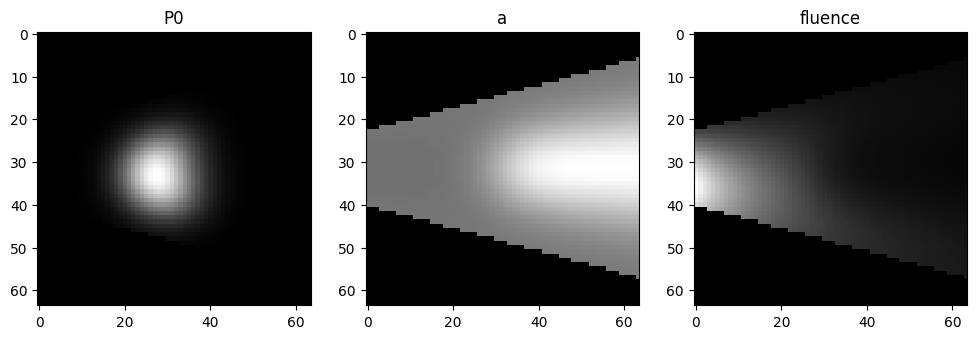

In [10]:
#Visualize
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].set_title("P0")
ax[1].set_title("a")
ax[2].set_title("fluence")

ax[0].imshow(P0_var_wedge, cmap = "gray")
ax[1].imshow(a_var_wedge, cmap = "gray")
ax[2].imshow(fluence_var_wedge, cmap = "gray")

---

<a id="mu_to_p0_cone_3d"></a>
# `mu_to_p0_cone_3d`



## Mathematical Description
The `mu_to_p0_cone_3d` function models light attenuation in a 3D space with a conical "flashlight" effect, characterized by an angular width (`theta`) and a specific direction vector. This function simulates a directional light source, similar to a cone-shaped beam.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y, z)} = 
\begin{cases} 
1 & \text{if } \arccos\left(\frac{\vec{d} \cdot \vec{v}}{\|\vec{d}\| \|\vec{v}\|}\right) \leq \frac{\theta}{2}\\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h
$$

$$
p_0(x, y, z) = 
\begin{cases} 
\mu(x, y, z) e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
\text{Fluence, } f(x, y, z) = 
\begin{cases} 
e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$
</span>

Where:
- $\theta$: Angular width of the conical beam.
- $\vec{d}$: Normalized direction vector of the beam.
- $\vec{v}$: Vector from the source point to a point in the field of view (FOV).
- $M(x, y, z)$: Mask determining the area affected by the beam in 3D.
- $a(x, y, z)$: Accumulated attenuation at each point $(x, y, z)$.
- $p_0(x, y, z)$: Initial amplitude at each point in the grid.
- $f(x, y, z)$: Fluence at each point.
- $d$: Euclidean distance from the source to $(x, y, z)$, calculated as $d = \sqrt{(x - x_s)^2 + (y - y_s)^2 + (z - z_s)^2}$.
- $n$: Number of discrete points along the ray, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i, z_i)$: Coordinates of the $i$-th point along the ray.
- $\mu(x, y, z)$: Attenuation coefficient at $(x, y, z)$.
- $h$: Spacing between sampling points.
- $\mu(x_i, y_i, z_i)$: Attenuation coefficient at the $i$-th point along the ray.


## Python Implementation

`mu_to_p0_cone_3d` and the GPU-parallelized function ,`mu_to_p0_cone_3d_gpu`, accepts and returns the following

Parameters
- `mu`: A numpy array representing the attenuation coefficients at each point in a 3D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source`: A tuple containing the x, y, and z coordinates of the light source.
- `h`: The spacing between sampling points along each ray.
- `xp`, `yp`, `zp`: Numpy arrays of x-coordinates and y-coordinates in the physical space.
- `direction_vector`: The direction vector in which the "flashlight" is pointed from the source.
- `theta`: The angular width of the "flashlight" cone.

Returns
- `p0`: The initial light intensity at each point in the grid.
- `a`: The accumulated attenuation at each point in the grid.
- `fluence`: The light fluence at each point in the grid.

## Example Usage


In [11]:
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    x, y, z = np.meshgrid(xp, yp, zp)
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    density = np.transpose(density, (2, 1, 0)) #convert to zyx
    return density

Lx = 10
Ly = 10
Lz = 10

nx = 32
ny = 32
nz = 32

dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .2

source = (-10, 0, 0)

P0_cone, a_cone, fluence_cone = mu_to_p0.mu_to_p0_cone_3d(mu, mu_background, source, dx/2, xc, yc, zc, [1,0,0], np.pi/10)

## GPU function call is identical here
## P0_cone, a_cone, fluence_cone = mu_to_p0_gpu.mu_to_p0_cone_3d_gpu(mu, mu_background, source, dx/2, xc, yc, zc, [1,0,0], np.pi/10)

# Visualize

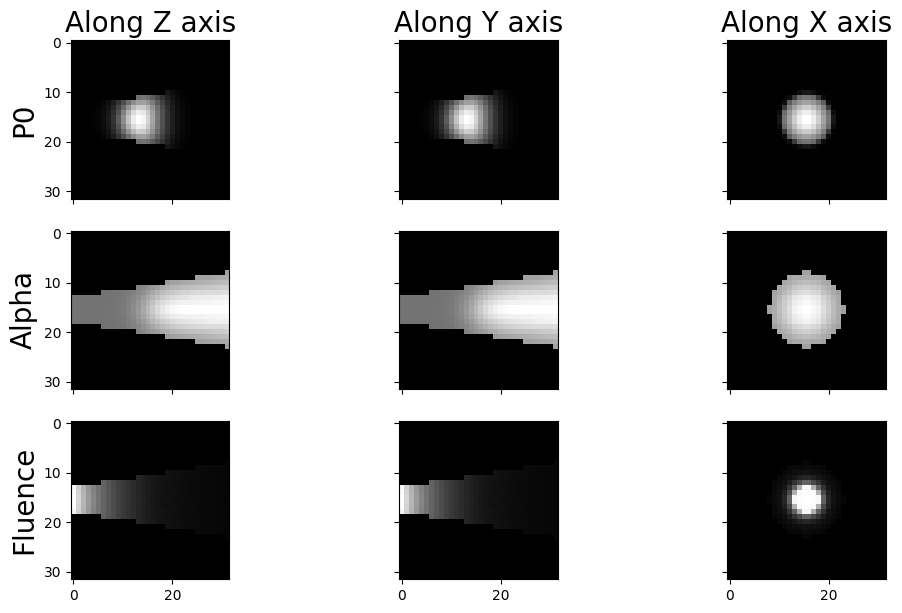

In [12]:
#Visualize
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True, sharey= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0_cone, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0_cone, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0_cone, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a_cone, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a_cone, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a_cone, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence_cone, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence_cone, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence_cone, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()

## Visualize I

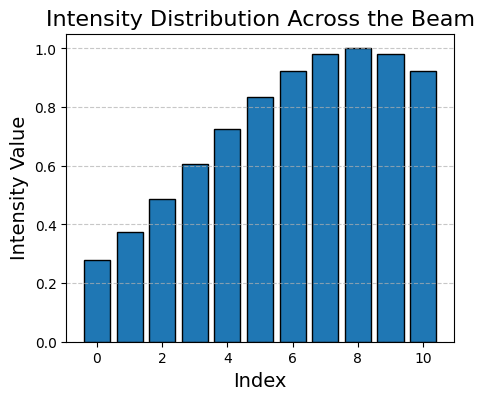

In [13]:
# Plotting
plt.figure(figsize=(5, 4))
plt.bar(x=range(len(I)), height=I, edgecolor='black')

# Adding labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Intensity Value', fontsize=14)
plt.title('Intensity Distribution Across the Beam', fontsize=16)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.show()

---

# `mu_to_p0_wedge_3d`
<a id="mu_to_p0_wedge_3d"></a>

## Mathematical Description
The `mu_to_p0_cone_3d` function models light attenuation in a 3D space with a wedge effect, characterized by an angular width (`theta`), a starting and end point for the wedge, and a specific direction vector.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y, z)} = 
\begin{cases} 
1 & \text{if } \left| \arctan2(y - y_s, x - x_s) - \text{ray\_direction} \right| \leq \frac{\theta}{2}\\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h
$$

$$
p_0(x, y, z) = 
\begin{cases} 
\mu(x, y, z) e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
f(x, y, z) = 
\begin{cases} 
e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$
</span>

Where : 
- $\theta$ is the angular width of the wedge beam.
- $\text{ray\_direction}$ is the direction around which the wedge is spread.
- $(x, y, z)$ are coordinates in the 3D space.
- $(x_s, y_s, z_s)$ and $(x_e, y_e, z_e)$ define the start and end points of the source of the wedge.
- $d$ is the Euclidean distance from the source to $(x, y, z)$.
- $n$ is the number of discrete points along the ray from the source to the point.
- $h$ is the spacing between sampling points along the ray.
- $\mu(x, y, z)$ is the attenuation coefficient at $(x, y, z)$.

## Python Implementation

The functions `mu_to_p0_cone_3d` and the GPU-Parallelized `mu_to_p0_wedge_3d_gpu` accept and return the following

Parameters : 
- `mu`: A 3D numpy array representing the attenuation coefficients at each point in the grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source_start`: A tuple containing the x, y, and z coordinates of the start point of the wedge beam.
- `source_end`: A tuple containing the x, y, and z coordinates of the end point of the wedge beam.

*  Important : This function only considers a source aligned to the z-axis. Specifying the x and y for the starting and end points of the source is only useful for moving the "apex" of the wedge across the x-y plane.

- `ray_direction`: The direction angle of the central axis of the wedge beam.
- `theta`: The angular width of the wedge beam.
- `h`: The spacing between sampling points along the ray.
- `xp, yp, zp`: Numpy arrays representing the x, y, and z coordinates in the physical space, respectively.
Returns : 
- `p0`: The initial light intensity at each point in the grid, calculated based on the wedge beam's spread and attenuation.
- `a`: The accumulated attenuation at each point in the grid, taking into account the distance from the source and the attenuation coefficients.
- `fluence`: The light fluence at each point in the grid, representing the light intensity after accounting for attenuation and the distribution of the wedge beam.



## Example Usage

In [14]:
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    x, y, z = np.meshgrid(xp, yp, zp)
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    density = np.transpose(density, (2, 1, 0)) #convert to zyx
    return density

Lx = 10
Ly = 10
Lz = 10

nx = 64
ny = 64
nz = 64

dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .2

source_start = np.array([-10, 0, -2.5]) #vertical source
source_end = np.array([-10, 0, 2.5])

#ray direction is defined as the rotational angle around the z-axis in radians
ray_direction = 0 #np.pi/10
theta = np.pi/10


P0_wedge3d, a_wedge3d, fluence_wedge3d = mu_to_p0.mu_to_p0_wedge_3d(mu, mu_background, source_start, source_end, ray_direction, theta, dx/2, xc, yc, zc)

# GPU Function Call
## P0_wedge3d, a_wedge3d, fluence_wedge3d = mu_to_p0_gpu.mu_to_p0_wedge_3d_gpu(mu, mu_background, source_start, source_end, ray_direction, theta, dx/2, xc, yc, zc)

## Visualize using Maximum Intensity Projections

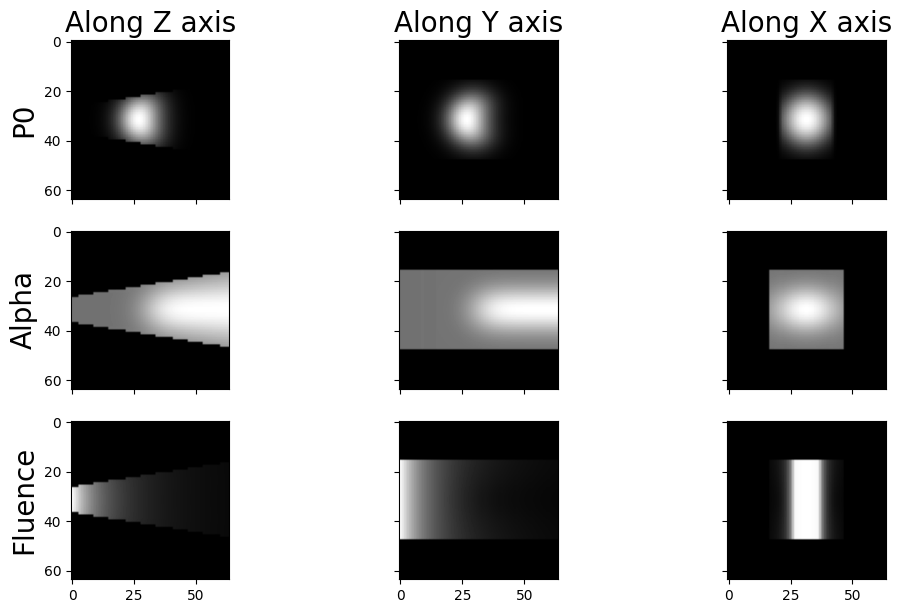

In [15]:
#Visualization 
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True, sharey= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0_wedge3d, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0_wedge3d, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0_wedge3d, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a_wedge3d, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a_wedge3d, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a_wedge3d, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence_wedge3d, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence_wedge3d, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence_wedge3d, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()

---

<a id="mu_to_p0_wedge_variable_beam_3d"></a>
# `mu_to_p0_wedge_variable_beam_3d`

## Mathematical Description
The mu_to_p0_wedge_variable_beam_3d function simulates light attenuation in a 3D space with a variable-intensity wedge-shaped beam, characterized by a specific angle (theta) and direction (ray_direction). This function is designed to model the behavior of a light source with directional characteristics, similar to a wedge beam, where the intensity varies along the different angles of the beam.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y, z)} = 
\begin{cases} 
1 & \text{if } |\arctan2(y - y_s, x - x_s) - \text{ray\_direction}| \leq \frac{\theta}{2} \\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h
$$

$$
p_0(x, y, z) = 
\begin{cases} 
\mu(x, y, z) e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
f(x, y, z) = 
\begin{cases} 
e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$


$$
I(\text{angle}) = 
\begin{cases} 
\frac{\theta_{\text{cw}} - \text{angle}}{d_{\theta}} \cdot I[\text{index}_{\text{cw}}] + \frac{\text{angle} - \theta_{\text{ccw}}}{d_{\theta}} \cdot I[\text{index}_{\text{ccw}}] & \text{if angle within the beam}
\end{cases}
$$

</span>

Where :

- $\theta_{cw}$ and $\theta_{ccw}$ are the angles immediately clockwise and counterclockwise to the angle, respectively, within the discretized intensity array $I$.
- $d_{\theta}$ is the angular increment between consecutive entries in the intensity array $I$.
- $index_{cw}$ and $index_{ccw}$ are the indices in the intensity array $I$ corresponding to $\theta_{cw}$ and $\theta_{ccw}$.
- angle is the angle at the current point relative to the direction of the wedge-shaped beam.
- $M(x, y, z)$: A mask determining the area affected by the variable-intensity wedge beam.
- $a(x, y, z)$: The accumulated attenuation at each point $(x, y, z)$.
- $p_0(x, y, z)$: The initial amplitude at each point in the grid.
- $f(x, y, z)$: The fluence at each point.
- $d$: The Euclidean distance from the source to point $(x, y, z)$, calculated as $d = \sqrt{(x - x_s)^2 + (y - y_s)^2 + (z - z_s)^2}$.
- $n$: The number of discrete points along the ray, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i, z_i)$: The coordinates of the $i$-th point along the ray.
- $\mu(x, y, z)$: The attenuation coefficient at point $(x, y, z)$.
- $h$: The spacing between sampling points along the ray.
- $\mu(x_i, y_i, z_i)$: The attenuation coefficient at the $i$-th point along the ray.
- $\theta$: The angular width of the wedge beam.
- $ray\_direction$: The orientation of the wedge beam.
- $I{(angle)}$: The interpolated intensity based on the angle within the beam.

## Python Implementation

The functions `mu_to_p0_wedge_variable_beam_3d` and the GPU-Parallelized `mu_to_p0_wedge_variable_beam_3d_gpu` accept and return the following

Parameters : 
- `mu`: A numpy array representing the attenuation coefficients at each point in a 3D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source_start`: A tuple containing the x, y, and z coordinates of the start point of the wedge beam.
- `source_end`: A tuple containing the x, y, and z coordinates of the end point of the wedge beam.
- `ray_direction`: The direction angle of the central axis of the wedge beam.
- `theta`: The angular width of the wedge beam.
- `h`: The spacing between sampling points along the ray.
- `xp, yp, zp`: Numpy arrays of x-coordinates, y-coordinates, and z-coordinates in the physical space, respectively.
- `I`: An array representing the intensity distribution of the beam across different angles within the wedge's spread.

Returns
- `p0`: The initial light intensity at each point in the grid.
- `a`: The accumulated attenuation at each point in the grid.
- `fluence`: The light fluence at each point in the grid.


## Example Usage


In [16]:
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    x, y, z = np.meshgrid(xp, yp, zp)
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    density = np.transpose(density, (2, 1, 0)) # convert to zyx
    return density
def create_gaussian_array(size, center, sigma): # for creating I
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

Lx = 10
Ly = 10
Lz = 10

nx = 64
ny = 64
nz = 64

dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .2

source_start = np.array([-10, 0, -3]) #vertical source
source_end = np.array([-10, 0, 3])

#ray direction is defined as the rotational angle around the z-axis in radians
ray_direction = 0
theta = np.pi/10

I_row = create_gaussian_array(11, 5, 5)
# I_row = np.ones(11)
I = np.array([I_row for _ in range(nz)])

P0_var_wedge3d, a_var_wedge3d, fluence_var_wedge3d = mu_to_p0.mu_to_p0_wedge_variable_beam_3d(mu, mu_background, source_start, source_end, ray_direction, theta, dx/2, xc, yc, zc, I)

#GPU function call
# P0_var_wedge3d, a_var_wedge3d, fluence_var_wedge3d = mu_to_p0_gpu.mu_to_p0_wedge_variable_beam_3d_gpu(mu, mu_background, source_start, source_end, ray_direction, theta, dx/2, xc, yc, zc, I)

## Visualization

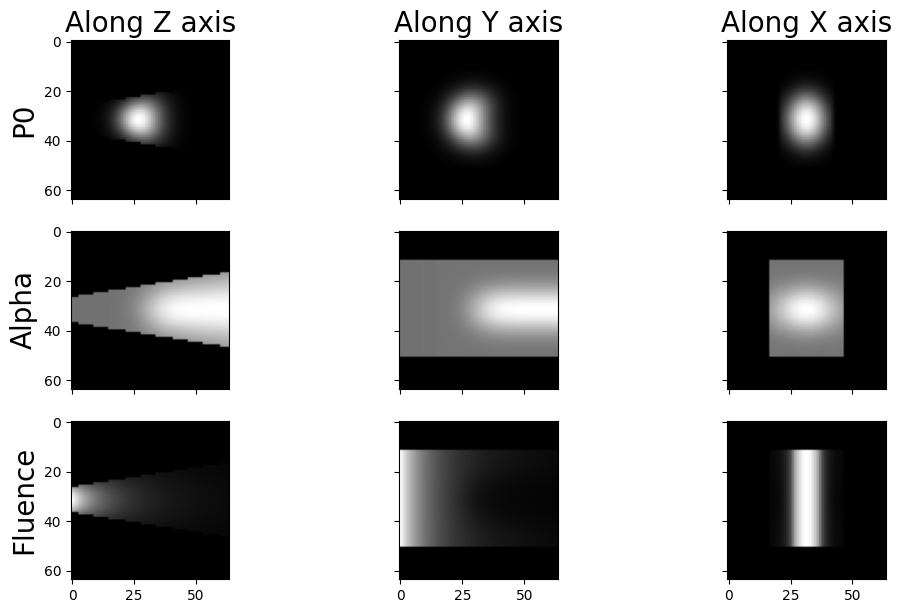

In [17]:
# Visualization
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True, sharey= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0_var_wedge3d, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0_var_wedge3d, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0_var_wedge3d, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a_var_wedge3d, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a_var_wedge3d, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a_var_wedge3d, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence_var_wedge3d, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence_var_wedge3d, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence_var_wedge3d, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()


---

<a id="mu_to_p0_cone_variable_beam_3d"></a>
# `mu_to_p0_cone_variable_beam_3d`

## Mathematical Description
The `mu_to_p0_cone_variable_beam_3d` function simulates light attenuation in a 3D space with a variable-intensity conical beam. The function models a beam whose intensity varies across different angles within its spread, using linear interpolation between intensities at discrete angular points.

<span style="font-size: 20px;">

$$
\text{Mask, M(x, y, z)} = 
\begin{cases} 
1 & \text{if } \arccos\left(\frac{\text{direction\_vector} \cdot \text{vector\_shift}}{\|\text{direction\_vector}\| \times \|\text{vector\_shift}\|}\right) \leq \frac{\theta}{2} \\
0 & \text{otherwise}
\end{cases}
$$

$$
I(\text{angle}) = 
\begin{cases} 
\frac{\theta - \text{inside\_ray\_theta}}{\text{d\_theta}} \cdot I[\text{inside\_ray\_i}] + \frac{\text{outside\_ray\_theta} - \theta}{\text{d\_theta}} \cdot I[\text{outside\_ray\_i}] & \text{if angle within the beam}
\end{cases}
$$

$$
a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h
$$

$$
p_0(x, y, z) = 
\begin{cases} 
\mu(x, y, z) e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
\text{Fluence, } f(x, y, z) = 
\begin{cases} 
e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

</span>

Where : 
- $\theta$: Angular width of the conical beam.
- $\vec{d}$: Normalized direction vector of the beam.
- $\vec{v}$: Vector from the source point to a point in the field of view (FOV).
- $M(x, y, z)$: Mask determining the area affected by the beam in 3D.
- $a(x, y, z)$: Accumulated attenuation at each point $(x, y, z)$.
- $p_0(x, y, z)$: Initial amplitude at each point in the grid.
- $f(x, y, z)$: Fluence at each point.
- $d$: Euclidean distance from the source to $(x, y, z)$, calculated as $d = \sqrt{(x - x_s)^2 + (y - y_s)^2 + (z - z_s)^2}$.
- $n$: Number of discrete points along the ray, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i, z_i)$: Coordinates of the $i$-th point along the ray.
- $\mu(x, y, z)$: Attenuation coefficient at $(x, y, z)$.
- $h$: Spacing between sampling points.
- $\mu(x_i, y_i, z_i)$: Attenuation coefficient at the $i$-th point along the ray.
- $I(\text{angle})$: Interpolated intensity at a given angle within the beam.
## Python Implementation
Parameters
- `mu`: A numpy array representing the attenuation coefficients at each point in a 3D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source`: A tuple containing the x, y, and z coordinates of the light source.
- `h`: The spacing between sampling points along each ray.
- `xp`, `yp`, `zp`: Numpy arrays of x-coordinates and y-coordinates in the physical space.
- `direction_vector`: The direction vector in which the "flashlight" is pointed from the source.
- `theta`: The angular width of the "flashlight" cone.
- `I`: An array representing the intensity of the light beam at different angles within the conical beam's spread. This array is used to calculate the variable intensity across the cone, allowing the simulation of a beam whose intensity varies with angle. The function employs linear interpolation between the discrete intensity values in this array to determine the intensity at specific points within the beam.

Returns
- `p0`: The initial light intensity at each point in the grid.
- `a`: The accumulated attenuation at each point in the grid.
- `fluence`: The light fluence at each point in the grid.


## Example Usage

In [18]:
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    x, y, z = np.meshgrid(xp, yp, zp)
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    return density

# Here we define a "realistic" Intensity array. Think about how flashlights are brighter in the middle, but gets darker further away from the center of the beam
def create_gaussian_array(size, center, sigma): # for creating I
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

Lx = 10
Ly = 10
Lz = 10

nx = 64
ny = 64
nz = 64

dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .2

source = (-10, 0, 0)

#ray direction is defined as the rotational angle around the z-axis in radians
ray_direction = 0
theta = np.pi/10
direction_vector = [1,0,0]

I = create_gaussian_array(11, 5, 5)

P0_Flashlight, a_Flashlight, fluence_Flashlight = mu_to_p0.mu_to_p0_cone_variable_beam_3d(mu, mu_background, source, dx/2, xc, yc, zc, direction_vector, theta, I)

## Visualize

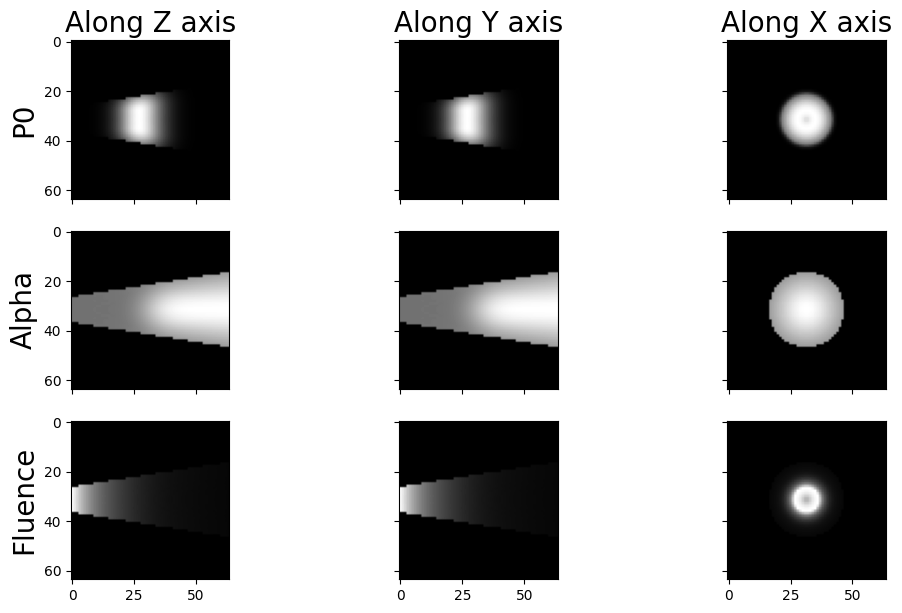

In [19]:
# Visualize
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True, sharey= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0_Flashlight, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0_Flashlight, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0_Flashlight, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a_Flashlight, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a_Flashlight, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a_Flashlight, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence_Flashlight, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence_Flashlight, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence_Flashlight, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()

## We can visualize the I array.

### This I array represents a light source with a bright center, which decays proportionally to the angular distance from the direction vector of the light source

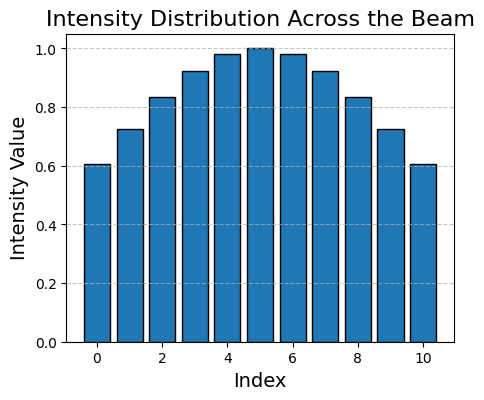

In [20]:
# Plotting
plt.figure(figsize=(5, 4))
plt.bar(x=range(len(I)), height=I, edgecolor='black')

# Adding labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Intensity Value', fontsize=14)
plt.title('Intensity Distribution Across the Beam', fontsize=16)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.show()

---

<a id="mu_to_p0_cone_stacked_cone"></a>
# `mu_to_p0_cone_stacked_cone`

## Mathematical Description
The mu_to_p0_cone_stacked_cone function models light attenuation in a 3D space with stacked, variable-intensity conical beams. Each beam is characterized by a direction vector (direction_vector), an angular width (theta), and an intensity distribution (I). This function simulates multiple conical beams stacked along the z-axis, each originating from different z-levels between source_start and source_end.

<span style="font-size: 20px;">

$$
\text{For each z-level from } z_s \text{ to } z_e:
$$

$$
\text{Mask, M(x, y, z)} = 
\begin{cases} 
1 & \text{if } \arccos\left(\frac{\vec{d} \cdot \vec{v}}{\|\vec{d}\| \|\vec{v}\|}\right) \leq \frac{\theta}{2}\\
0 & \text{otherwise}
\end{cases}
$$

$$
a(x, y, z) = \sum_{i=0}^{n-1} \mu(x_i, y_i, z_i) h
$$

$$
p_0(x, y, z) = 
\begin{cases} 
\sum \mu(x, y, z) e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

$$
f(x, y, z) = 
\begin{cases} 
\sum e^{-a(x, y, z)} \left(\frac{3}{4 \pi d^3}\right) \cdot I(\text{angle}) & \text{if M(x, y, z) = 1} \\
0 & \text{otherwise}
\end{cases}
$$

</span>

Where:

- $\theta$: Angular width of the conical beam.
- $\vec{d}$: Normalized direction vector of the beam.
- $\vec{v}$: Vector from the source point to a point in the field of view (FOV).
- $M(x, y, z)$: Mask determining the area affected by the beam in 3D.
- $a(x, y, z)$: Accumulated attenuation at each point $(x, y, z)$.
- $p_0(x, y, z)$: Initial amplitude at each point in the grid.
- $f(x, y, z)$: Fluence at each point.
- $d$: Euclidean distance from the source to $(x, y, z)$, calculated as $d = \sqrt{(x - x_s)^2 + (y - y_s)^2 + (z - z_s)^2}$.
- $n$: Number of discrete points along the ray, calculated as $n = \text{int}(d/h) + 1$.
- $(x_i, y_i, z_i)$: Coordinates of the $i$-th point along the ray.
- $\mu(x, y, z)$: Attenuation coefficient at $(x, y, z)$.
- $h$: Spacing between sampling points.
- $\mu(x_i, y_i, z_i)$: Attenuation coefficient at the $i$-th point along the ray.
- $I(\text{angle})$: Interpolated intensity at a given angle within the beam.
- $z_s$, $z_e$: Start and end z-coordinates of the stacked beams.

This function calculates the cumulative light attenuation and fluence from multiple conical beams, each contributing to the overall effect at different z-levels in the 3D grid.

## Python Implementation
Parameters : 
- `mu`: A numpy array representing the attenuation coefficients at each point in a 3D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `source_start`, source_end: Tuples containing the start and end coordinates (x, y, z) for the stacked conical beams.
- `h`: The spacing between sampling points along the ray.
- `xp, yp, zp`: Numpy arrays of x-coordinates, y-coordinates, and z-coordinates in the physical space, respectively.
- `direction_vector`: The direction vector of the conical beams.
- `theta`: The angular width of the conical beams.
- `I`: An array representing the intensity distribution of the beams across different angles within their spread.

Returns : 
- `p0`: The cumulative initial light intensity at each point in the grid from all beams.
- `a`: The accumulated attenuation at each point in the grid (remains unchanged as only one beam is active at a time along z-axis).
- `fluence`: The cumulative light fluence at each point in the grid from all beams.
## Example Usage

In [21]:
# Instead of a Gaussian Ball, here, we create an opaque vertical cylinder with adjustable radius and length as a "Blood Vessel" Phantom
def create_blood_vessel_tube(xp, yp, zp, radius, length): 
    nx, ny, nz = xp.shape[0], yp.shape[0], zp.shape[0]
    dz = zp[1] - zp[0]
    phantom = np.zeros((nx, ny, nz))

    center_x = (max(xp) + min(xp)) / 2
    center_y = (max(yp) + min(yp)) / 2
    
    z_start = (len(zp) // 2 ) - int((np.floor((length / 2) / dz)))
    z_end = (len(zp) // 2 ) + int((np.floor((length / 2) / dz)))

    for i in range(nx):
        for j in range(ny):
            for k in range(z_start, z_end):
                xi = xp[i] #physical coordinates
                yi = yp[j]

                
                distance = np.sqrt((xi - center_x)**2 + (yi - center_y)**2)
                # if k == 0 : 
                #     #print(distance, xi , yi, distance < radius)
                if distance < radius:
                    phantom[i, j, k] = 1
                    
    phantom = np.transpose(phantom, (2, 1, 0))
    return phantom

def create_gaussian_array(size, center, sigma): # for creating I
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian


Lx = 1
Ly = 1
Lz = 3

nx = 20
ny = 20
nz = 60

dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

length = Lz
radius = 0.1
mu = create_blood_vessel_tube(xc, yc, zc, radius, length)
mu_background = .2

source_start = np.array([-1, 0, -1]) #vertical source, xyz
source_end = np.array([-1, 0, 1])

#ray direction is defined as the rotational angle around the z-axis in radians
direction_vector = [1,0,0]
theta = np.pi/4

I = create_gaussian_array(11, 5, 5)



#P0, a, fluence = mu_to_p0.mu_to_p0_wedge_variable_beam_3d(mu, mu_background, source_start, source_end, ray_direction, theta, dx/2, xc, yc, zc, I)
P0, a, fluence = mu_to_p0.mu_to_p0_cone_stacked_cone (mu, mu_background, source_start, source_end, dx/2, xc, yc, zc, direction_vector, theta, I)

## Visualization

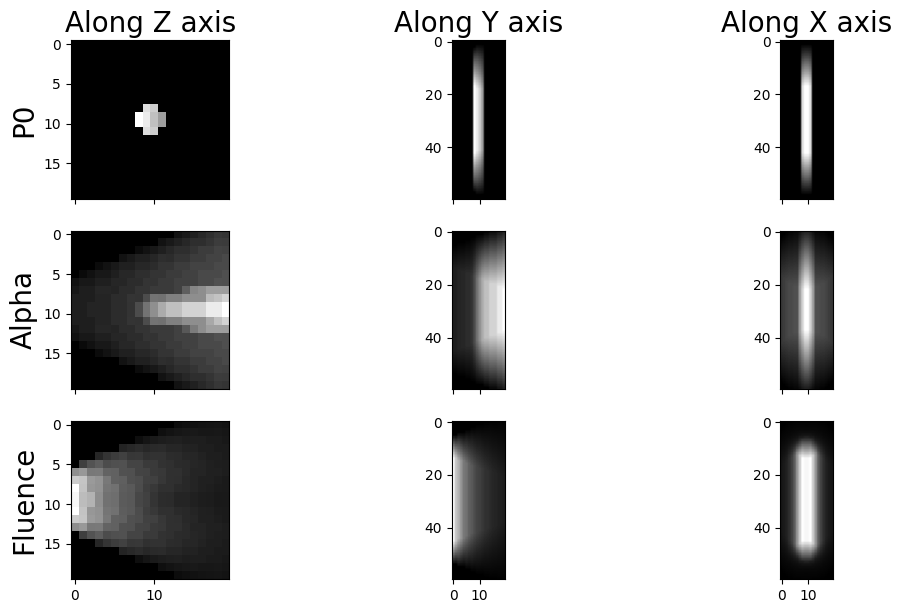

In [22]:
# Visualize
fig, ax = plt.subplots(3, 3, figsize=(12,7), sharex= True)
ax[0,0].set_title("Along Z axis", fontsize = 20)
ax[0,1].set_title("Along Y axis", fontsize = 20)
ax[0,2].set_title("Along X axis", fontsize = 20)

ax[0,0].imshow(np.max(P0, axis = 0), cmap = 'gray')
ax[0,1].imshow(np.max(P0, axis = 1), cmap = 'gray')
ax[0,2].imshow(np.max(P0, axis = 2), cmap = 'gray')

ax[1,0].imshow(np.max(a, axis = 0), cmap = 'gray')
ax[1,1].imshow(np.max(a, axis = 1), cmap = 'gray')
ax[1,2].imshow(np.max(a, axis = 2), cmap = 'gray')

ax[2,0].imshow(np.max(fluence, axis = 0), cmap = 'gray')
ax[2,1].imshow(np.max(fluence, axis = 1), cmap = 'gray')
ax[2,2].imshow(np.max(fluence, axis = 2), cmap = 'gray')

ax[0,0].set_ylabel("P0", fontsize = 20)
ax[1,0].set_ylabel("Alpha", fontsize = 20)
ax[2,0].set_ylabel("Fluence", fontsize = 20)

plt.show()

---

<a id="p0_to_H_wedge"></a>
# `p0_to_H_wedge`

## Mathematical Description

The p0_to_H_wedge function computes a transformation matrix H for initial amplitude data (p0) in a 2D grid, mapping it to various angles within a wedge-shaped beam. This beam is characterized by its direction (direction) and angular width (theta). The function calculates how each point in the amplitude data contributes to different angles within the wedge beam's spread, based on the intensity distribution (I).

<span style="font-size: 20px;">

$$ 
\text{For each point in the 2D grid (flattened to a column vector)}:
$$

$$
\text{Compute the angle relative to the direction vector and determine contributions:} \\
\text{angle} = \arctan2(y_i - y_s, x_i - x_s)
$$

$$
\text{If angle within wedge limits } (\theta_{start}\ to\   \theta_{end}):
$$

$$
\text{Determine indices and weights for interpolation within I} \\
$$

$$
H[m, \text{index}_{\text{cw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{cw}} \\
H[m, \text{index}_{\text{ccw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{ccw}}
$$
</span>

Where:

- $m$: Index in the flattened p0 array.
- $p0_{\text{flat}}[m]$: Value at index m in the flattened p0 array.
- $angle$: Angle between the point in the grid and the direction.
- $theta_start, theta_end$: Start and end angles of the wedge beam.
- $index_{\text{cw}}, index_{\text{ccw}}$: Indices in the intensity array I for the angles immediately clockwise and counterclockwise to the calculated angle.
- $weight_{\text{cw}}, weight_{\text{ccw}}$: Weights for linear interpolation based on the distance of angle from the nearest discretized angles in I.

## Python Implementation

Parameters

- `p0`: A numpy array representing the initial amplitude at each point in a 2D grid from a wedge-shaped beam.
- `I`: An array representing the intensity distribution of the wedge beam across different angles.
- `source`: A tuple containing the x and y coordinates of the light source.
- `xc, yc`: Numpy arrays of x-coordinates and y-coordinates in the physical space, respectively.
- `theta`: The angular width of the wedge beam.
- `direction`: The direction angle of the central axis of the wedge beam.

Returns
- `H`: A matrix representing the contribution of each point in p0 to various angles within the wedge beam's spread.
Example Usage

In [42]:
import inverse_problem

# Function to create a Gaussian density pattern in 2D
def gauss_density_pattern(xp, yp, amplitude, sigma):
    # Generate a meshgrid for 2D coordinates
    x, y = np.meshgrid(xp, yp)
    # Determine the center of the Gaussian distribution
    x0 = xp.mean()
    y0 = yp.mean()
    # Compute the Gaussian density
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    return density

# Function to create a 1D Gaussian array, used for creating intensity distribution 'I'
def create_gaussian_array(size, center, sigma):
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

# Setting up the dimensions and creating coordinate arrays
Lx, Ly = 10, 10
nx, ny = 64, 64
dx, dy = Lx/nx, Ly/ny
xc, yc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx), np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)

# Generating a Gaussian density pattern for mu
mu = gauss_density_pattern(xc, yc, .50, Lx/10)
mu_background = .20

# Creating a Gaussian array for intensity I
I = create_gaussian_array(11, 9, 5)
direction, theta = 0, np.pi / 10
source = (-10, 0)

# Simulating pressure (P0) for a wedge-shaped beam with variable intensity
P0_original, a_original, fluence_original = mu_to_p0.mu_to_p0_wedge_variable_beam(mu, mu_background, source, dx/4, xc, yc, theta, direction, I)

# Simulating pressure for a standard wedge-shaped beam
P0, a, fluence = mu_to_p0.mu_to_p0_wedge(mu, mu_background, source, dx/4, xc, yc, theta, direction)

# Transforming P0 to matrix H using the inverse problem function
H = inverse_problem.p0_to_H_wedge(P0, I, source, xc, yc, theta, direction)

# Applying the transformation and reshaping to get new P0 values
y = np.dot(H, I)
P0_new = y.reshape(mu.shape[0], -1)


## Visualize

True


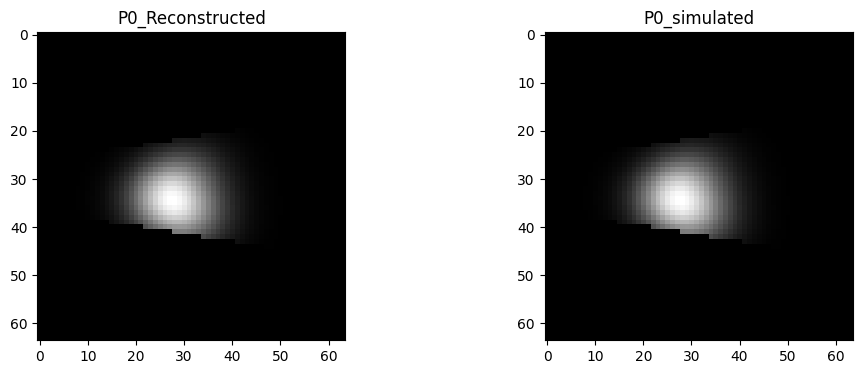

In [43]:
# Visualizing and comparing the original and new P0 arrays
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("P0_Reconstructed")
ax[1].set_title("P0_simulated")
ax[0].imshow(P0_new, cmap = "gray")
ax[1].imshow(P0_original, cmap = "gray")

# Checking if the original and new P0 arrays are close to each other
print(np.allclose(P0_original, P0_new, atol= 0.00001))

plt.show()

---

<a id="p0_to_H_cone"></a>
# `p0_to_H_cone`

## Mathematical Description
The p0_to_H_cone function transforms initial amplitude data (p0) from a conical beam into a matrix H that represents the contribution of each point in the amplitude data to various angles within the conical beam. This transformation is based on the direction of the beam (direction_vector), the angular width of the cone (theta), and the intensity distribution (I).

<span style="font-size: 20px;">

$$
\text{For each point in the 3D grid}:
$$

$$
\text{Angle Calculation, } \text{angle} = 
\arccos\left(\frac{\vec{d} \cdot \vec{v}}{\|\vec{d}\| \|\vec{v}\|}\right)
$$

$$
\text{If angle} \leq \theta:
\text{Determine indices and weights for interpolation within I}
$$

$$
H[m, \text{index}_{\text{cw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{cw}}
$$

$$
H[m, \text{index}_{\text{ccw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{ccw}}
$$

</span>

Where:
- $m$: Index in the flattened p0 array.
- $p0_{\text{flat}}[m]$: Value at index m in the flattened p0 array.
- $angle$: Angle between the point in the grid and the direction_vector.
- $index_{\text{cw}}, index_{\text{ccw}}$: Indices in the intensity array I corresponding to angles immediately clockwise and counterclockwise to the calculated angle.
- $weight_{\text{cw}}, weight_{\text{ccw}}$: Weights for linear interpolation based on the distance of angle from the nearest discretized angles in I.

## Python Implementation
Parameters
- `p0`: A numpy array representing the initial amplitude at each point in a 3D grid from a conical beam.
- `I`: An array representing the intensity distribution of the conical beam across different angles.
- `source`: A tuple containing the x, y, and z coordinates of the light source.
- `xc, yc, zc`: Numpy arrays of x-coordinates, y-coordinates, and z-coordinates in the physical space, respectively.
- `theta`: The angular width of the conical beam.
- `direction_vector`: The direction vector of the conical beam.

Returns
- `H`: A matrix representing the contribution of each point in p0 to various angles within the conical beam's spread.

## Example Usage



In [38]:
import inverse_problem

# Function to create a 3D Gaussian density distribution
def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    # Create a meshgrid for 3D coordinates
    x, y, z = np.meshgrid(xp, yp, zp)
    # Calculate the center of the Gaussian distribution
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    # Compute the Gaussian density
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    return density

# Function to create a 1D Gaussian array (used for intensity I)
def create_gaussian_array(size, center, sigma):
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

# Define the dimensions of the grid
Lx, Ly, Lz = 10, 10, 10
nx, ny, nz = 50, 50, 50

# Calculate grid spacing
dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

# Create coordinate arrays for the grid
xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

# Generate a 3D Gaussian distribution for mu
mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .2

# Create an asymmetric Gaussian array for intensity I
I = create_gaussian_array(11, 9, 5)

# Define parameters for the conical beam
theta = np.pi / 10
source = (-10, 0, 0)
direction_vector = [1,0,0]

# Calculate initial amplitude (P0), attenuation (a), and fluence for a variable beam cone
P0_original, a_original, fluence_original = mu_to_p0.mu_to_p0_cone_variable_beam_3d(mu, mu_background, source, dx/2, xc, yc, zc, direction_vector, theta, I)

# Calculate initial amplitude, attenuation, and fluence for a standard cone
P0, a, fluence = mu_to_p0.mu_to_p0_cone_3d(mu, mu_background, source, dx/2, xc, yc, zc, direction_vector, theta)

# Transform P0 to matrix H using the inverse problem function
H = inverse_problem.p0_to_H_cone(P0, I, source, xc, yc, zc, theta, direction_vector)

# Dot product of H and I to get new P0 values
y = np.dot(H, I)
P0_new = y.reshape(mu.shape[0], mu.shape[0], -1)


## Visualize with Maximum Intensity Projections

True


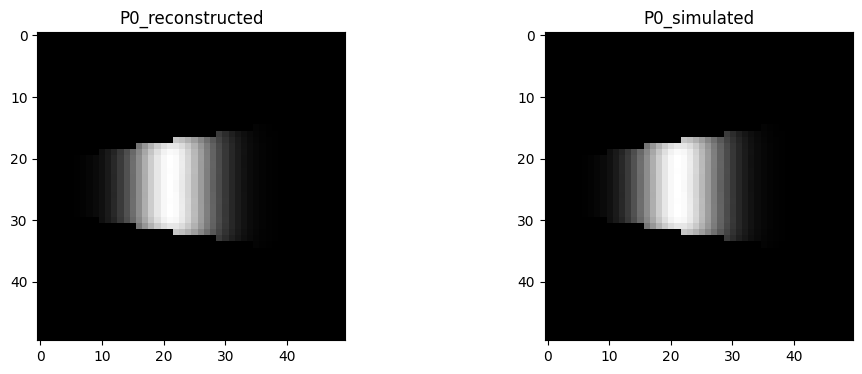

In [39]:
# Plotting the original and new P0 arrays
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("P0_reconstructed")
ax[1].set_title("P0_simulated")
ax[0].imshow(np.max(P0_new, axis = 1), cmap = "gray")
ax[1].imshow(np.max(P0_original, axis = 1), cmap = "gray")

# Check if the original and new P0 arrays are close to each other
print(np.allclose(P0_original, P0_new, atol= 0.00001))

plt.show()

---

<a id="p0_to_sparseH_cone"></a>
# `p0_to_sparseH_cone`

# Matehmatical Description

The p0_to_sparseH_cone function computes a sparse transformation matrix H for initial amplitude data (p0) in a 3D grid, mapping it to various angles within a conical beam. The conical beam is characterized by its direction (direction_vector) and angular width (theta). The function calculates how each point in the amplitude data contributes to different angles within the conical beam's spread, based on the intensity distribution (I).

<span style="font-size: 20px;">

$$
\text{For each point in the 3D grid (flattened to a column vector)}:
$$

$$
\text{Compute the angle relative to the direction vector and determine contributions:} \\
\text{angle} = \arccos\left(\frac{\vec{d} \cdot \vec{v}}{\|\vec{d}\| \|\vec{v}\|}\right)
$$

$$
\text{If angle} \leq \frac{\theta}{2}:
\text{Determine indices and weights for interpolation within I} \\
H[m, \text{index}_{\text{cw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{cw}} \\
H[m, \text{index}_{\text{ccw}}] += p0_{\text{flat}}[m] \times \text{weight}_{\text{ccw}}
$$

</span>

Where:
- $m$: Index in the flattened p0 array.
- $p0_{\text{flat}}[m]$: Value at index m in the flattened p0 array.
- $angle$: Angle between the point in the grid and the direction_vector.
- $index_{\text{cw}}, index_{\text{ccw}}$: Indices in the intensity array I corresponding to angles immediately clockwise and counterclockwise to the calculated angle.
- $weight_{\text{cw}}, weight_{\text{ccw}}$: Weights for linear interpolation based on the distance of angle from the nearest discretized angles in I.

## Python Implementation
Parameters
- `p0`: A numpy array representing the initial amplitude at each point in a 3D grid from a conical beam.
- `I`: An array representing the intensity distribution of the conical beam across different angles.
- `source`: A tuple containing the x, y, and z coordinates of the light source.
- `xc, yc, zc`: Numpy arrays of x-coordinates, y-coordinates, and z-coordinates in the physical space, respectively.
- `theta`: The angular width of the conical beam.
- `direction_vector`: The direction vector of the conical beam.

Returns
- `H`: A sparse matrix representing the contribution of each point in p0 to various angles within the conical beam's spread.

## Example Usage

In [35]:
import inverse_problem


def gauss_density_pattern(xp, yp, zp, amplitude, sigma):
    x, y, z = np.meshgrid(xp, yp, zp)
    x0 = xp.mean()
    y0 = yp.mean()
    z0 = zp.mean()
    density = amplitude * np.exp(-((x - x0)**2 + (y - y0)**2 + (z - z0)**2) / (2 * sigma**2))
    return density

def create_gaussian_array(size, center, sigma): # for creating I
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

Lx = 10
Ly = 10
Lz = 10

nx = 30
ny = 30
nz = 30

dx = Lx/nx
dy = Ly/ny
dz = Lz/nz


xc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx)
yc = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny)
zc = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

mu = gauss_density_pattern(xc, yc, zc, .5, Lx/10)
mu_background = .20

I = create_gaussian_array(11, 9, 5) #create assymetric gaussian array to test
theta = np.pi / 10
source = (-10, 0, 0)
direction_vector = [1,0,0]


P0_original, a_original, fluence_original = mu_to_p0.mu_to_p0_cone_variable_beam_3d(mu, mu_background, source, dx/2, xc, yc, zc, direction_vector, theta, I)
P0, a, fluence = mu_to_p0.mu_to_p0_cone_3d(mu, mu_background, source, dx/2, xc, yc, zc, direction_vector, theta)
sparse_H = inverse_problem.p0_to_sparseH_cone(P0, I, source, xc, yc, zc, theta, direction_vector)

y = sparse_H.dot(I)
P0_new = y.reshape(mu.shape[0], mu.shape[0], -1)


## Visualize with Maximum Intensity Projections

True


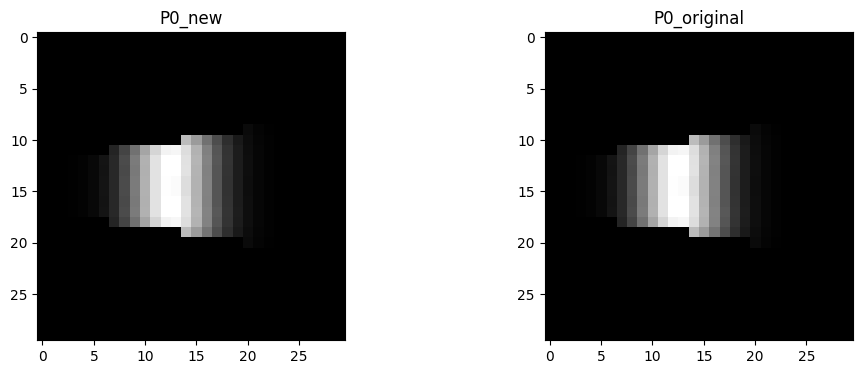

In [37]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("P0_new")
ax[1].set_title("P0_original")

ax[0].imshow(np.max(P0_new, axis = 1), cmap = "gray")
ax[1].imshow(np.max(P0_original, axis = 1), cmap = "gray")

print(np.allclose(P0_original, P0_new, atol= 0.00001))

plt.show()

---

<a id="p0_to_H_stackedCone"></a>
# `p0_to_H_stackedCone`

## Mathematical Description

The p0_to_H_stackedCone function computes a transformation matrix H for a series of stacked conical beams in a 3D space. Each beam is generated at different z-levels between source_start and source_end, characterized by a direction vector (direction_vector), an angular width (theta), and an intensity distribution (I). The function calculates the transformation matrix for each conical beam and then stacks these matrices to form a comprehensive transformation matrix representing all beams.

<span style="font-size: 20px;">

$$
\text{For each z-level from } z_s \text{ to } z_e:
$$

$$
\text{Compute p0, alpha, and fluence for a single cone at z-level} \\
H_{\text{cone}} = \text{p0\_to\_sparseH\_cone}(p0_{\text{single\_cone}}, I, \text{source at z-level}, xp, yp, zp, \theta, \text{direction\_vector}) \\
$$

$$
\text{Stack H matrices:} \\
\text{If first iteration: } H_{\text{stack}} = H_{\text{cone}} \\
\text{Else: } H_{\text{stack}} = \text{hstack}(H_{\text{stack}}, H_{\text{cone}})
$$

</span>

- $\theta$: Angular width of the conical beams.
- $direction\_vector$: Normalized direction vector of the beams.
- $H_{\text{cone}}$: Transformation matrix for a single conical beam at a specific z-level.
- $H_{\text{stack}}$: Cumulative transformation matrix representing all conical beams in the stack.
- $zp$: Array of z-coordinates.
- $z_s, z_e$: Start and end z-coordinates of the stacked beams.

## Python Implementation
Parameters
- `mu`: A numpy array representing the attenuation coefficients at each point in a 3D grid.
- `mu_background`: A constant value representing the background attenuation coefficient.
- `h`: The spacing between sampling points along the ray.
- `source_start, source_end`: Tuples containing the start and end coordinates (x, y, z) for the stacked conical beams.
- `xp, yp, zp`: Numpy arrays of x-coordinates, y-coordinates, and z-coordinates in the physical space, respectively.
- `direction_vector`: The direction vector of the conical beams.
- `theta`: The angular width of the conical beams.
- `I`: An array representing the intensity distribution of the beams across different angles within their spread.

Returns
- `H_stack`: A comprehensive transformation matrix representing the cumulative effect of all stacked conical beams.

## Example Usage


In [40]:
# Function to create a cylindrical (tube-like) structure, representing a blood vessel
def create_blood_vessel_tube(xp, yp, zp, radius, length):
    nx, ny, nz = xp.shape[0], yp.shape[0], zp.shape[0]
    dz = zp[1] - zp[0]
    phantom = np.zeros((nx, ny, nz))

    center_x = (max(xp) + min(xp)) / 2
    center_y = (max(yp) + min(yp)) / 2
    
    z_start = (len(zp) // 2 ) - int((np.floor((length / 2) / dz)))
    z_end = (len(zp) // 2 ) + int((np.floor((length / 2) / dz)))
    for i in range(nx):
        for j in range(ny):
            for k in range(z_start, z_end):
                xi = xp[i]
                yi = yp[j]
                distance = np.sqrt((xi - center_x)**2 + (yi - center_y)**2)
                if distance < radius:
                    phantom[i, j, k] = 1
    phantom = np.transpose(phantom, (2, 1, 0))
    return phantom

# Function to create a Gaussian array, used for creating intensity distribution 'I'
def create_gaussian_array(size, center, sigma):
    x = np.arange(size)
    gaussian = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gaussian

# Setting up the dimensions and creating coordinate arrays
Lx, Ly, Lz = 1, 1, 3
nx, ny, nz = 10, 10, 20
dx, dy, dz = Lx / nx, Ly / ny, Lz / nz
xc, yc, zc = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, nx), np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, ny), np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, nz)

# Creating a blood vessel tube phantom
length, radius = Lz, 0.1
mu = create_blood_vessel_tube(xc, yc, zc, radius, length)
mu_background = .2

# Defining source and beam parameters
source_start, source_end = np.array([-1, 0, -1]), np.array([-1, 0, 1])
direction_vector, theta = [1,0,0], np.pi/4
I_control, I = np.ones(11), create_gaussian_array(11, 6, 5)

# Simulating amplitude (P0) for a stacked cone beam
P0_original, a_original, fluence_original = mu_to_p0.mu_to_p0_cone_stacked_cone(mu, mu_background, source_start, source_end, dx/2, xc, yc, zc, direction_vector, theta, I)

# Creating a transformation matrix for the stacked cone beam
shortFat_H = inverse_problem.p0_to_H_stackedCone(mu, mu_background, dx/2, source_start, source_end, xc, yc, zc, direction_vector, theta, I_control)

# Creating a tall intensity array (tall_I) by stacking 'I' for each z level
tall_I = np.zeros((len(I) * nz))
for z in range(nz):
    tall_I[z * len(I): (z * len(I)) + len(I)] = I

# Applying the transformation and reshaping to get new P0 values
y = shortFat_H.dot(tall_I)
P0_new = y.reshape(nz, ny, -1)


## Visualize with Maximum Intensity Projection 

True


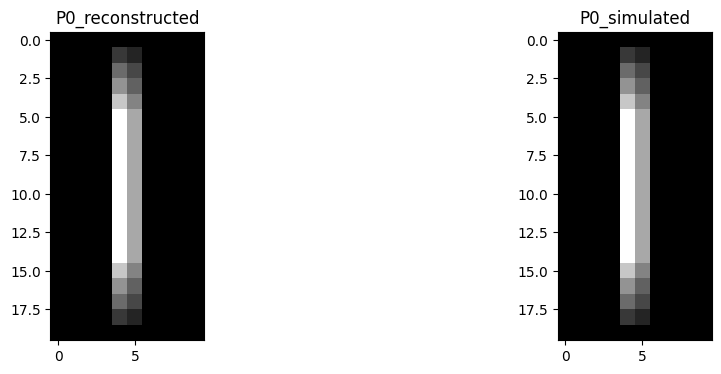

In [33]:
# Visualizing and comparing the original and new P0
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("P0_reconstructed")
ax[1].set_title("P0_simulated")
ax[0].imshow(np.max(P0_new, axis = 1), cmap = "gray")
ax[1].imshow(np.max(P0_original, axis = 1), cmap = "gray")
print(np.allclose(P0_original, P0_new, atol= 0.000001))